In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score 

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

base_path = os.getcwd() + '/csvFiles/'
try:
    data_path = base_path + 'rough_surface_statistics.csv'
    rough_dat = pd.read_csv(data_path, header = None)
    feature_name = rough_dat.iloc[0, :].values
    data_rough = rough_dat.iloc[1:, 1:-1].values.astype(float)
    labels = rough_dat.iloc[1:, -1].values
    case_names = rough_dat.iloc[1:, 0].values
except FileNotFoundError:
    print(f"File not found: {data_path}")


id_DNS,id_DNSle,id_DNSF,id_EXP,id_DNSlc = np.where((labels == 'DNS'))[0],np.where((labels == 'DNSLE'))[0],np.where((labels == 'DNSF'))[0],np.where((labels == 'EXP'))[0],np.where((labels == 'DNSLC'))[0]
print(f"DNS: {len(id_DNS)}, DNSLE: {len(id_DNSle)}, DNSLC: {len(id_DNSlc)}, DNSF: {len(id_DNSF)}, EXP: {len(id_EXP)}")
print(f"Total used cases: {data_rough.shape[0]}")


used_col = [0, 1, 4, 5, 6, 8, 9, 11, 12, 13]
input_data = data_rough[:, used_col]
Sx,kavg,krms,Ra,Ix,Po,Ex,Sk,Ku,ks = input_data[:,0].reshape(-1, 1), input_data[:,1].reshape(-1, 1), \
    input_data[:,2].reshape(-1, 1), input_data[:,3].reshape(-1, 1), \
    input_data[:,4].reshape(-1, 1), input_data[:,5].reshape(-1, 1), \
    input_data[:,6].reshape(-1, 1), input_data[:,7].reshape(-1, 1), \
    input_data[:,8].reshape(-1, 1), input_data[:,9].reshape(-1, 1)
kt,Iz,Ez = data_rough[:,3].reshape(-1, 1) , data_rough[:,7].reshape(-1, 1), data_rough[:,10].reshape(-1, 1)  # kt, Iz, Ez


# Helper Funcs
def cos(x):
    return np.cos(x)
def tanh(x):
    return np.tanh(x)
def exp(x):
    return np.exp(x)
def square(x):
    return np.square(x)
def abs(x):
    return np.abs(x)


DNS: 28, DNSLE: 24, DNSLC: 8, DNSF: 31, EXP: 13
Total used cases: 104


In [48]:
def parse_equation(eq_str):
    expr = eq_str.split('=')[1].strip()
    for i in range(1,6):
        expr = expr.replace(f'#{i}',f'x{i}')

    return expr


def parse_equation_sepTerm(sr_str):

    varName_id = [1, 2, 3, 5, 4]  # Po, Ex, Sk, kavg, Sx
    expr_concatenated = f''
    terms = [p.strip() for p in sr_str.split(';') if p.strip()]
    for i in range(len(terms)):
        term = terms[i].split('=')[1].strip()
        term_replaced = term.replace(f'#1',f'x{varName_id[i]}')
        expr_concatenated += '(' + term_replaced + ')'
        if i != len(terms) - 1:
            expr_concatenated += ' * '

    return expr_concatenated


def make_func(expr):
    def func(X):
        x1, x2, x3, x4, x5 = X[:,0], X[:,1], X[:,2], X[:,3], X[:,4]
        calc_ = eval(expr)
        return calc_.reshape(-1, 1)
    return func


def print_model_metrics(df, tra_or_tol = 'train'):
    if tra_or_tol == 'total':
        id_used_ = np.concatenate((id_DNS, id_DNSle,id_DNSlc, id_DNSF, id_EXP))
    elif tra_or_tol == 'train':
        id_used_ = np.where((labels != 'DNSLC'))[0]
    mare = []
    mae = []
    modIn_data = np.concatenate([Po[id_used_],Ex[id_used_],Sk[id_used_],Sx[id_used_],kavg[id_used_]], axis=1)
    Out_target = ks[id_used_]/krms[id_used_]

    complex_id = df['Complexity'].values

    for i in range(len(df)):
        expr = df['parsed_eq'].iloc[i]
        f = make_func(expr)
        Y_pred = f(modIn_data)
        mean_abs_rel_error = np.mean(np.abs((Y_pred - Out_target)/Out_target))
        mean_abs_error = np.mean(np.abs(Y_pred - Out_target))
        mare.append(mean_abs_rel_error)
        mae.append(mean_abs_error)

    #     print(f"{complex_id[i]} MARE: {mean_abs_rel_error*100:.2f}% | MAE: {mean_abs_error:.4f}")
    # print(f'----------------------------------\n')
    complex_id_ = np.array(complex_id).reshape(-1,1)
    mare = np.array(mare).reshape(-1,1)*100
    mae = np.array(mae).reshape(-1,1)
    return np.concatenate([complex_id_, mare, mae], axis=1)

In [55]:
# print metrics
path_srMod = {'Notemp': os.path.join(base_path,'hall_of_fame_noTemplate.csv'),
                'Temp': os.path.join(base_path,'hall_of_fame_withTemplate.csv')}
df1 = pd.read_csv(path_srMod['Notemp'])
df1['parsed_eq'] = df1['Equation'].apply(parse_equation)

df2 = pd.read_csv(path_srMod['Temp'])
df2['parsed_eq'] = df2['Equation'].apply(parse_equation_sepTerm)

In [56]:
import mpl_toolkits.axes_grid1.inset_locator as inset_locator

me1 = print_model_metrics(df1, tra_or_tol = 'train')
me2 = print_model_metrics(df2, tra_or_tol = 'train')
me3 = print_model_metrics(df1, tra_or_tol = 'total')
me4 = print_model_metrics(df2, tra_or_tol = 'total')


xlab_sz,ylab_sz,title_sz = 14.5,14.5,0
xy_tick_sz,lgd_sz,letter_sz = 14,0,15.5
inset_tick_sz = 13

lw_width , marker_sz = 2.5, 3
inset_lw_width , inset_marker_sz = 2, 6

C:\Users\admin\AppData\Local\Temp\ipykernel_4100\3194590907.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


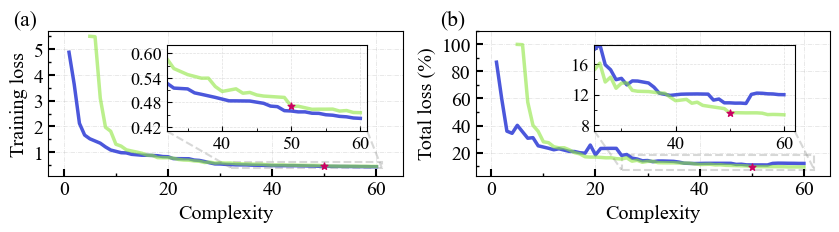

In [57]:
# 
def plot_train(ax):
    idx = np.where(me2[:,0] == 50)
    ax.scatter(me2[:,0][idx], me2[:,2][idx], color='#cb0162', marker='*', s=25, zorder=3,label='Selected')
    ax.plot(me1[:,0],me1[:,2], label=r'$\mathrm{NoTemplate}$', color='#4b57db',linewidth=lw_width, )
    ax.plot(me2[:,0],me2[:,2], label=r'$\mathrm{SepTemplate}$', color='#8ee53f',linewidth=lw_width, alpha=0.6)

    ax.set_xlabel('Complexity', fontsize=xlab_sz )
    ax.set_ylabel('Training loss', fontsize=ylab_sz)
    ax.set_xlim(-3, 65)
    ax.set_ylim(0.1,5.7)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='both', which='major', direction='in', labelsize=xy_tick_sz,
                   length=5, width=1.5,)
    ax.tick_params(axis='both', which='minor', direction='in',
                   length=2.5, width=1,)
    ax.grid(True, linestyle='-.', linewidth=0.5, alpha=0.4)
    ax.text(-0.1, 1.15, "(a)", transform=ax.transAxes, ha='left', va='top', fontsize=letter_sz)

    #
    ax_inset = inset_locator.inset_axes(ax, width="85%", height="85%",
                                        loc='upper right',
                                        bbox_to_anchor=(0.255, 0.25, 0.665, 0.7),
                                        bbox_transform=ax.transAxes)
    ax_inset.scatter(me2[:,0][idx], me2[:,2][idx], color='#cb0162', marker='*', s=25, zorder=3,label='Selected')
    ax_inset.plot(me1[:,0],me1[:,2], label=r'$\mathrm{NoTemplate}$', color='#4b57db',linewidth=lw_width, )
    ax_inset.plot(me2[:,0],me2[:,2], label=r'$\mathrm{SepTemplate}$', color='#8ee53f',linewidth=lw_width, alpha=0.6)

    ax_inset.set_xlim(32, 61)
    ax_inset.set_ylim(0.41, 0.62)
    ax_inset.yaxis.set_major_locator(MultipleLocator(0.06))
    ax_inset.xaxis.set_major_locator(MultipleLocator(10))
    ax_inset.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax_inset.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax_inset.tick_params(axis='both', which='major', direction='in', labelsize=inset_tick_sz,
                         )
    ax_inset.tick_params(axis='both', which='minor', direction='in',
                        )
    ax_inset.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
    inset_locator.mark_inset(ax, ax_inset, loc1=3, loc2=4, fc="none", linestyle='--', ec="#7d7f7c", lw=1.5, alpha=0.3)


def plot_total(ax):
    idx = np.where(me4[:,0] == 50)
    ax.scatter(me4[:,0][idx], me4[:,1][idx], color='#cb0162', marker='*', s=25, zorder=3,label='Selected')
    ax.plot(me3[:,0],me3[:,1], label=r'$\mathrm{NoTemplate total}$', color='#4b57db',linewidth=lw_width, )
    ax.plot(me4[:,0],me4[:,1], label=r'$\mathrm{SepTemplate total}$', color='#8ee53f',linewidth=lw_width, alpha=0.6)

    ax.set_xlabel('Complexity', fontsize=xlab_sz)
    ax.set_ylabel('Total loss (%)', fontsize= ylab_sz)
    ax.set_xlim(-3, 65)
    ax.set_ylim(3, 110)
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='both', which='major', direction='in', labelsize=xy_tick_sz,
                   length=5, width=1.5,)
    ax.tick_params(axis='both', which='minor', direction='in',
                   length=2.5, width=1,)
    ax.grid(True, linestyle='-.', linewidth=0.5, alpha=0.4)
    ax.text(-0.1, 1.15, "(b)", transform=ax.transAxes, ha='left', va='top', fontsize=letter_sz)

    # 
    ax_inset = inset_locator.inset_axes(ax, width="85%", height="85%",
                                        loc='upper right',
                                        bbox_to_anchor=(0.255, 0.25, 0.665, 0.7),
                                        bbox_transform=ax.transAxes)
    ax_inset.scatter(me4[:,0][idx], me4[:,1][idx], color='#cb0162', marker='*', s=25, zorder=3,label='Selected')
    ax_inset.plot(me3[:,0],me3[:,1], label=r'$\mathrm{NoTemplate}$', color='#4b57db',linewidth=lw_width, )
    ax_inset.plot(me4[:,0],me4[:,1], label=r'$\mathrm{SepTemplate}$', color='#8ee53f',linewidth=lw_width, alpha=0.6)

    ax_inset.set_xlim(25, 62)
    ax_inset.set_ylim(7.2, 18.5)
    ax_inset.yaxis.set_major_locator(MultipleLocator(4))
    ax_inset.xaxis.set_major_locator(MultipleLocator(20))
    ax_inset.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax_inset.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax_inset.tick_params(axis='both', which='major', direction='in', labelsize=inset_tick_sz)
    ax_inset.tick_params(axis='both', which='minor', direction='in')
    ax_inset.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
    # ax_inset.legend(loc='upper right', fontsize=lgd_sz-2, ncol=1, columnspacing=0.5, framealpha=0.8)
    inset_locator.mark_inset(ax, ax_inset, loc1=3, loc2=4, fc="none", linestyle='--', ec="#7d7f7c", lw=1.5, alpha=0.3)



fig, axes = plt.subplots(1, 2, figsize=(8.5, 2.5))
plot_train(axes[0])
plot_total(axes[1])
plt.tight_layout()
# plt.savefig('metric_loss.pdf',format = 'pdf',bbox_inches='tight')
plt.show()

